In [1]:
%load_ext autoreload
%autoreload 2

# Import all required modules and configuration
from io_utils import process_perp_futures_data, save_optData, save_dataset_dict
from config import *
from data_utils import (
    align_time_series_fast, GroupMinMaxScaler, pivot_features_and_costs,
    split_train_test_by_time_quantile, print_memory, truncate_outliers, 
    compute_technical_features, truncate_target_variable, save_model_parameters,
    process_and_combine_shared
)
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pandas as pd
import numpy as np
import os
import gc

# Explicitly import optimization parameters from config
from config import (
    N, RISK_ABS, SINGLE_ABS, L1_ABS, SIGMA_ABS, TURNOVER,
    TRUNCATION_THRESHOLD, TRAIN_TEST_SPLIT_RATIO,
    get_constraint_matrices, get_covariance_matrix, get_risk_factor
)
os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")

print("‚úÖ ÊâÄÊúâÊ®°ÂùóÂíåÂèÇÊï∞ÂØºÂÖ•ÂÆåÊàê")
print(f"‰ºòÂåñÂèÇÊï∞: N={N}, RISK_ABS={RISK_ABS}, SINGLE_ABS={SINGLE_ABS}")
print(f"           L1_ABS={L1_ABS}, SIGMA_ABS={SIGMA_ABS}, TURNOVER={TURNOVER}")

Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
‚úÖ ÊâÄÊúâÊ®°ÂùóÂíåÂèÇÊï∞ÂØºÂÖ•ÂÆåÊàê
‰ºòÂåñÂèÇÊï∞: N=13, RISK_ABS=1.5, SINGLE_ABS=0.1
           L1_ABS=1.0, SIGMA_ABS=2.5, TURNOVER=0.5


=== ÂºÄÂßãÊï∞ÊçÆÂ§ÑÁêÜÊµÅÁ®ã ===
Êï∞ÊçÆÊñá‰ª∂Â§πÂ≠òÂú®: /scratch/gpfs/sl3965/datasets/perp_futures_klines
ÊâæÂà∞ 341 ‰∏™ parquet Êñá‰ª∂
Ê≠£Âú®ËØªÂèñÊï∞ÊçÆÊñá‰ª∂...


Âè™ËØªÂèñÂâç7‰∏™symbolÊñá‰ª∂:   0%|          | 0/7 [00:00<?, ?it/s]

ÂêàÂπ∂ÊâÄÊúâÊï∞ÊçÆ...
Êï∞ÊçÆÈ¢ÑËßà:
            open_time     open     high      low    close    volume  count  \
0 2025-01-01 00:00:00  0.19955  0.19959  0.19916  0.19959  140561.0    259   
1 2025-01-01 00:01:00  0.19960  0.19986  0.19952  0.19986   50449.0    146   
2 2025-01-01 00:02:00  0.19988  0.20033  0.19986  0.20033   89781.0    170   
3 2025-01-01 00:03:00  0.20037  0.20077  0.20037  0.20052  509099.0    477   
4 2025-01-01 00:04:00  0.20052  0.20095  0.20052  0.20074  166762.0    256   

    symbol  
0  GRTUSDT  
1  GRTUSDT  
2  GRTUSDT  
3  GRTUSDT  
4  GRTUSDT  

Êï∞ÊçÆ‰ø°ÊÅØ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917280 entries, 0 to 917279
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   open_time  917280 non-null  datetime64[ns]
 1   open       917280 non-null  float64       
 2   high       917280 non-null  float64       
 3   low        917280 non-null  float64       
 4  

/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io

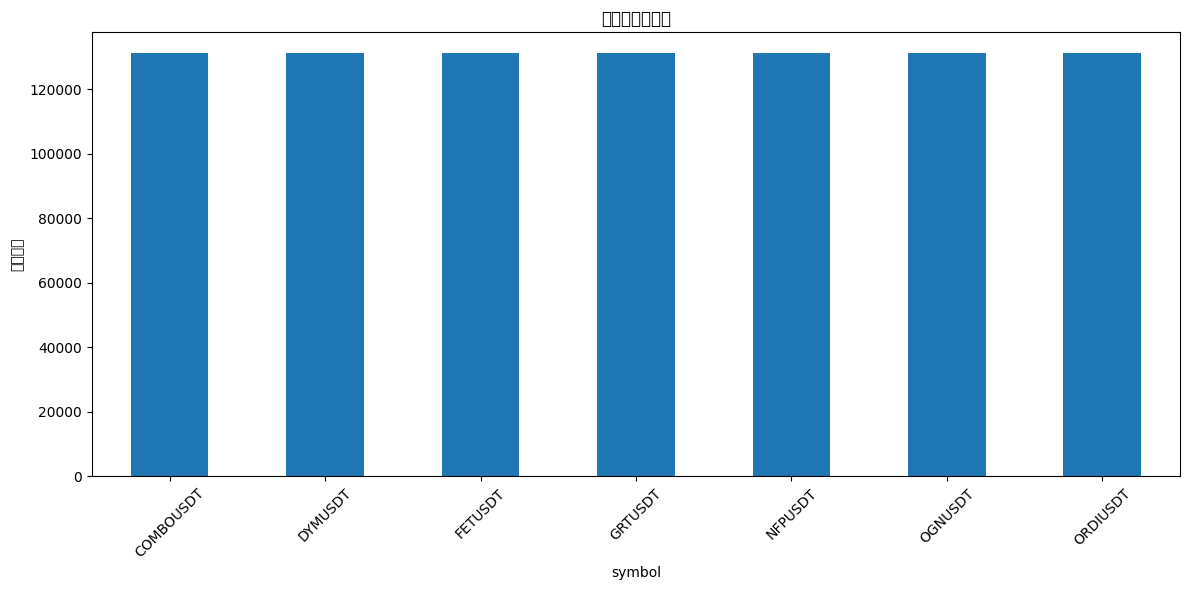


ÁâπÂæÅÁªüËÆ°‰ø°ÊÅØ:
                open           high            low          close  \
count  917070.000000  917070.000000  917070.000000  917070.000000   
mean        2.506209       2.508892       2.503487       2.506185   
std         5.811707       5.817487       5.805858       5.811653   
min         0.052400       0.053000       0.052300       0.052400   
25%         0.116100       0.116253       0.116000       0.116100   
50%         0.298700       0.299000       0.298500       0.298700   
75%         0.798400       0.799400       0.797400       0.798400   
max        30.373000      30.399000      30.204000      30.373000   

             volume          count  
count  9.170700e+05  917070.000000  
mean   5.041740e+04     204.959139  
std    1.385716e+05     390.452960  
min    0.000000e+00       0.000000  
25%    4.262700e+03      33.000000  
50%    1.632005e+04      86.000000  
75%    5.121975e+04     238.000000  
max    1.253997e+07   23905.000000  

ÁõÆÊ†áÂèòÈáèÁªüËÆ°‰ø°ÊÅ

1.1608238220214844

In [2]:
# Data Processing Pipeline
print("=== ÂºÄÂßãÊï∞ÊçÆÂ§ÑÁêÜÊµÅÁ®ã ===")

# Step 1: Process raw data
combined_df = process_perp_futures_data(data_path=RAW_DATA_PATH, output_path=PROCESSED_DATA_PATH)
print_memory("Âä†ËΩΩÊï∞ÊçÆÂêé")

# Step 2: Align time series
aligned_df = align_time_series_fast(combined_df)
print_memory("Êó∂Èó¥ÂØπÈΩêÂêé")

# Step 3: Data cleaning and feature engineering
print("\nÂºÄÂßãÊï∞ÊçÆÊ∏ÖÁêÜÂíåÁâπÂæÅÂ∑•Á®ã...")
aligned_df = truncate_outliers(aligned_df, truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("outlier truncationÂêé")

aligned_df = compute_technical_features(aligned_df, group_by_column='symbol')
print_memory("ËÆ°ÁÆóÊäÄÊúØÊåáÊ†áÁâπÂæÅÂêé")

aligned_df = truncate_target_variable(aligned_df, target_col=Y_COL, 
                                    truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("Y_COL truncationÂêé")

# Step 4: Save processed data
aligned_df.to_parquet(ALIGNED_CRYPTO_DATA_PATH)
print("Êó∂Èó¥ÂØπÈΩêÂêéÁöÑÊï∞ÊçÆ‰ø°ÊÅØÔºö")
print(f"Shape: {aligned_df.shape}")
print(aligned_df.head())

# Step 5: Train/Test split
train_df, test_df = split_train_test_by_time_quantile(aligned_df, time_col='open_time', frac=TRAIN_TEST_SPLIT_RATIO)
print(f"Train Êó∂Èó¥ËåÉÂõ¥: {train_df['open_time'].min()} ‚Äî {train_df['open_time'].max()}")
print(f"Test  Êó∂Èó¥ËåÉÂõ¥: {test_df['open_time'].min()} ‚Äî {test_df['open_time'].max()}")

# Clean up memory
del combined_df, aligned_df
gc.collect()
print_memory("Êï∞ÊçÆÂ§ÑÁêÜÂÆåÊàê")

In [3]:
# Training Data Processing and Model Parameter Setup
print("=== ËÆ≠ÁªÉÊï∞ÊçÆÂ§ÑÁêÜÂíåÊ®°ÂûãÂèÇÊï∞ËÆæÁΩÆ ===")

# Step 1: Scale training data
scaler = GroupMinMaxScaler(feature_range=(-1,1), target_columns=X_COLS, group_by_column='symbol')
print("ÂØπËÆ≠ÁªÉÈõÜÂÅöscale")
train_df = scaler.fit_transform(train_df)
print_memory("scale train_df Âêé")

# Step 2: Pivot and save training data
print("pivot features and costs")
features, costs, unique_times, unique_symbols = pivot_features_and_costs(train_df, y_col=Y_COL, x_cols=X_COLS)
save_optData(features, costs, unique_times, unique_symbols, X_COLS, name=OPTDATA_NAME, save_dir=TRAIN_OPTDATA_DIR)
print_memory("pivot train_df Âêé")

del train_df
gc.collect()
print_memory("Âà†Èô§train_dfÂêé") 

# Step 3: Update global N and save model parameters
N = features.shape[1] 
print(f"Êõ¥Êñ∞ËµÑ‰∫ßÊï∞Èáè: N = {N}")

# Save model parameters using config + data_utils functions
A, b, l, u, risk_f, cov_matrix = save_model_parameters(N, costs, save_regular=True, save_testing=True)

# Validate model creation
try:
    model = build_market_neutral_model(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS)
    print("‚úÖ Â∏∏ËßÑÊ®°ÂûãÂàõÂª∫ÊàêÂäü")
except Exception as e:
    print(f"‚ùå Â∏∏ËßÑÊ®°ÂûãÂàõÂª∫Â§±Ë¥•: {e}")

try:
    model_testing = build_market_neutral_model_testing(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS, TURNOVER)
    print("‚úÖ ÊµãËØïÊ®°ÂûãÂàõÂª∫ÊàêÂäü")
except Exception as e:
    print(f"‚ùå ÊµãËØïÊ®°ÂûãÂàõÂª∫Â§±Ë¥•: {e}")

# Step 4: Process test data
test_df = scaler.transform(test_df)
test_features, test_costs, _, _ = pivot_features_and_costs(test_df, y_col=Y_COL, x_cols=X_COLS)
os.makedirs(TEST_DATA_DIR, exist_ok=True)
np.save(f"{TEST_DATA_DIR}/features_{OPTDATA_NAME}.npy", test_features)

del test_df
gc.collect()
print_memory("ÊµãËØïÊï∞ÊçÆÂ§ÑÁêÜÂÆåÊàê") 

=== ËÆ≠ÁªÉÊï∞ÊçÆÂ§ÑÁêÜÂíåÊ®°ÂûãÂèÇÊï∞ËÆæÁΩÆ ===
ÂØπËÆ≠ÁªÉÈõÜÂÅöscale
 scale train_df Âêé: 1.28 GB
pivot features and costs
Data shape: features (104808, 7, 21), costs (104808, 7)
Data saved to ./train_data with name 'crypto_data'
 pivot train_df Âêé: 1.42 GB
 Âà†Èô§train_dfÂêé: 1.21 GB
Êõ¥Êñ∞ËµÑ‰∫ßÊï∞Èáè: N = 7
‰øùÂ≠òÂ∏∏ËßÑÊ®°ÂûãÂèÇÊï∞...
‰øùÂ≠òÊµãËØïÊ®°ÂûãÂèÇÊï∞...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu
‚úÖ Â∏∏ËßÑÊ®°ÂûãÂàõÂª∫ÊàêÂäü
‚úÖ ÊµãËØïÊ®°ÂûãÂàõÂª∫ÊàêÂäü
Data shape: features (26202, 7, 21), costs (26202, 7)
 ÊµãËØïÊï∞ÊçÆÂ§ÑÁêÜÂÆåÊàê: 1.21 GB


1.206024169921875

# Optional: Use subset for testing
subset_size = 1000
features = features[:subset_size]
costs = costs[:subset_size]
test_features = test_features[:subset_size]
test_costs = test_costs[:subset_size]

print("Êï∞ÊçÆÂ≠êÈõÜÂ§ßÂ∞è:")
print(f"features shape: {features.shape}")
print(f"costs shape: {costs.shape}")
print(f"test_features shape: {test_features.shape}")
print(f"test_costs shape: {test_costs.shape}")

In [4]:
# Precompute Optimization Dataset
print("=== È¢ÑËÆ°ÁÆó‰ºòÂåñÊï∞ÊçÆÈõÜ ===")

if __name__ == "__main__":
    # Process training dataset
    print("Â§ÑÁêÜËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...")
    dataset_dict = process_and_combine_shared(
        features=features,
        costs=costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(dataset_dict, DATASET_DICT_PATH)
    print("‚úÖ ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ‰øùÂ≠òÂÆåÊàê")
    
    # Process testing dataset  
    print("Â§ÑÁêÜÊµãËØïÊï∞ÊçÆÈõÜ...")
    test_dataset_dict = process_and_combine_shared(
        features=test_features,
        costs=test_costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(test_dataset_dict, TEST_DATASET_DICT_PATH)
    print("‚úÖ ÊµãËØïÊï∞ÊçÆÈõÜ‰øùÂ≠òÂÆåÊàê")
    
    print("\nüéâ Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ")

=== È¢ÑËÆ°ÁÆó‰ºòÂåñÊï∞ÊçÆÈõÜ ===
Â§ÑÁêÜËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...

=== Êï∞ÊçÆÈ™åËØÅ ===
Features range: [-1.0000, 1.0000]
Costs range: [-0.0147, 0.0145]
Covariance matrix min eigenvalue: 0.000006
Covariance matrix condition number: 4.83e+01
Max possible L1 norm: 0.70, Required L1: 1.00
‚úÖ Êï∞ÊçÆÈ™åËØÅÈÄöËøá

 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 0 Âà∞ 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.40it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 500 Âà∞ 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 1000 Âà∞ 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.15it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 1500 Âà∞ 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.20it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 2000 Âà∞ 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 2500 Âà∞ 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.53it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 3000 Âà∞ 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 3500 Âà∞ 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.47it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 4000 Âà∞ 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.67it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 4500 Âà∞ 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.00it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 5000 Âà∞ 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 5500 Âà∞ 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.84it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 6000 Âà∞ 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.15it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 6500 Âà∞ 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.49it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 7000 Âà∞ 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.05it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 7500 Âà∞ 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.78it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 8000 Âà∞ 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.74it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 8500 Âà∞ 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.49it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 9000 Âà∞ 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.30it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 9500 Âà∞ 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.72it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 10000 Âà∞ 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.98it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 10500 Âà∞ 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.92it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 11000 Âà∞ 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.42it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 11500 Âà∞ 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.11it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 12000 Âà∞ 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 369.29it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 12500 Âà∞ 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.21it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 13000 Âà∞ 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.89it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 13500 Âà∞ 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.43it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 14000 Âà∞ 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 14500 Âà∞ 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.42it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 15000 Âà∞ 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.30it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 15500 Âà∞ 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.82it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 16000 Âà∞ 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.55it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 16500 Âà∞ 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.30it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 17000 Âà∞ 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.43it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 17500 Âà∞ 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 18000 Âà∞ 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.87it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 18500 Âà∞ 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.29it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 19000 Âà∞ 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 345.01it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 19500 Âà∞ 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.14it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 20000 Âà∞ 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.38it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 20500 Âà∞ 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.41it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 21000 Âà∞ 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.68it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 21500 Âà∞ 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 22000 Âà∞ 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.65it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 22500 Âà∞ 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.32it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 23000 Âà∞ 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 23500 Âà∞ 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.01it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 24000 Âà∞ 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.56it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 24500 Âà∞ 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.15it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 25000 Âà∞ 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.41it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 25500 Âà∞ 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 26000 Âà∞ 26499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.95it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 26500 Âà∞ 26999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 27000 Âà∞ 27499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 369.28it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 27500 Âà∞ 27999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 324.02it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 28000 Âà∞ 28499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.24it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 28500 Âà∞ 28999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.24it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 29000 Âà∞ 29499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.39it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 29500 Âà∞ 29999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.08it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 30000 Âà∞ 30499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.02it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 30500 Âà∞ 30999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.11it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 31000 Âà∞ 31499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.95it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 31500 Âà∞ 31999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.93it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 32000 Âà∞ 32499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.51it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 32500 Âà∞ 32999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.44it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 33000 Âà∞ 33499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.89it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 33500 Âà∞ 33999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.98it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 34000 Âà∞ 34499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.09it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 34500 Âà∞ 34999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.81it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 35000 Âà∞ 35499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.35it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 35500 Âà∞ 35999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.84it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 36000 Âà∞ 36499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 36500 Âà∞ 36999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.98it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 37000 Âà∞ 37499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.47it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 37500 Âà∞ 37999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.35it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 38000 Âà∞ 38499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.37it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 38500 Âà∞ 38999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.82it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 39000 Âà∞ 39499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.76it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 39500 Âà∞ 39999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.49it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 40000 Âà∞ 40499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.35it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 40500 Âà∞ 40999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.74it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 41000 Âà∞ 41499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.71it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 41500 Âà∞ 41999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.81it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 42000 Âà∞ 42499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.47it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 42500 Âà∞ 42999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.39it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 43000 Âà∞ 43499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.75it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 43500 Âà∞ 43999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 44000 Âà∞ 44499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.00it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 44500 Âà∞ 44999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.50it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 45000 Âà∞ 45499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 45500 Âà∞ 45999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.33it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 46000 Âà∞ 46499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.73it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 46500 Âà∞ 46999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.92it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 47000 Âà∞ 47499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 47500 Âà∞ 47999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.65it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 48000 Âà∞ 48499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.43it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 48500 Âà∞ 48999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.76it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 49000 Âà∞ 49499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 370.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 49500 Âà∞ 49999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.33it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 50000 Âà∞ 50499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 369.10it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 50500 Âà∞ 50999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.38it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 51000 Âà∞ 51499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.50it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 51500 Âà∞ 51999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 358.63it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 52000 Âà∞ 52499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.50it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 52500 Âà∞ 52999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.12it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 53000 Âà∞ 53499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.53it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 53500 Âà∞ 53999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.25it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 54000 Âà∞ 54499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.34it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 54500 Âà∞ 54999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.64it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 55000 Âà∞ 55499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.01it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 55500 Âà∞ 55999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.08it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 56000 Âà∞ 56499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 56500 Âà∞ 56999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.95it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 57000 Âà∞ 57499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 57500 Âà∞ 57999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.36it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 58000 Âà∞ 58499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.25it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 58500 Âà∞ 58999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.88it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 59000 Âà∞ 59499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.39it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 59500 Âà∞ 59999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.90it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 60000 Âà∞ 60499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.51it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 60500 Âà∞ 60999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 345.01it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 61000 Âà∞ 61499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.50it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 61500 Âà∞ 61999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.51it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 62000 Âà∞ 62499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.70it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 62500 Âà∞ 62999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.68it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 63000 Âà∞ 63499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.20it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 63500 Âà∞ 63999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.02it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 64000 Âà∞ 64499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.00it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 64500 Âà∞ 64999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 65000 Âà∞ 65499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.22it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 65500 Âà∞ 65999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 66000 Âà∞ 66499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.93it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 66500 Âà∞ 66999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.59it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 67000 Âà∞ 67499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.08it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 67500 Âà∞ 67999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.74it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 68000 Âà∞ 68499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.55it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 68500 Âà∞ 68999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.87it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 69000 Âà∞ 69499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.10it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 69500 Âà∞ 69999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.02it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 70000 Âà∞ 70499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.39it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 70500 Âà∞ 70999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 71000 Âà∞ 71499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.34it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 71500 Âà∞ 71999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.06it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 72000 Âà∞ 72499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.96it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 72500 Âà∞ 72999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.73it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 73000 Âà∞ 73499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.89it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 73500 Âà∞ 73999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.93it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 74000 Âà∞ 74499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.71it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 74500 Âà∞ 74999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.33it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 75000 Âà∞ 75499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.13it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 75500 Âà∞ 75999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.29it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 76000 Âà∞ 76499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.83it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 76500 Âà∞ 76999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.96it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 77000 Âà∞ 77499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.77it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 77500 Âà∞ 77999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.11it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 78000 Âà∞ 78499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.10it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 78500 Âà∞ 78999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.38it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 79000 Âà∞ 79499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.62it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 79500 Âà∞ 79999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 80000 Âà∞ 80499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.88it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 80500 Âà∞ 80999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.53it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 81000 Âà∞ 81499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.83it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 81500 Âà∞ 81999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.47it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 82000 Âà∞ 82499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.36it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 82500 Âà∞ 82999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.82it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 83000 Âà∞ 83499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.04it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 83500 Âà∞ 83999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.10it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 84000 Âà∞ 84499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 316.63it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 84500 Âà∞ 84999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.52it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 85000 Âà∞ 85499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.94it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 85500 Âà∞ 85999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.69it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 86000 Âà∞ 86499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 86500 Âà∞ 86999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.75it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 87000 Âà∞ 87499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.72it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 87500 Âà∞ 87999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.70it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 88000 Âà∞ 88499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.28it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 88500 Âà∞ 88999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 369.49it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 89000 Âà∞ 89499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.79it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 89500 Âà∞ 89999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.67it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 90000 Âà∞ 90499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.77it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 90500 Âà∞ 90999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.87it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 91000 Âà∞ 91499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.33it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 91500 Âà∞ 91999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 340.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 92000 Âà∞ 92499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.71it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 92500 Âà∞ 92999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.51it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 93000 Âà∞ 93499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.42it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 93500 Âà∞ 93999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.91it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 94000 Âà∞ 94499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.60it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 94500 Âà∞ 94999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.68it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 95000 Âà∞ 95499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.01it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 95500 Âà∞ 95999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.94it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 96000 Âà∞ 96499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.42it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 96500 Âà∞ 96999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.95it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 97000 Âà∞ 97499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.82it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 97500 Âà∞ 97999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.04it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 98000 Âà∞ 98499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.32it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 98500 Âà∞ 98999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.85it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 99000 Âà∞ 99499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.76it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 99500 Âà∞ 99999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.26it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 100000 Âà∞ 100499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.34it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 100500 Âà∞ 100999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.89it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 101000 Âà∞ 101499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.57it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 101500 Âà∞ 101999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 102000 Âà∞ 102499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.22it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 102500 Âà∞ 102999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.67it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 103000 Âà∞ 103499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.41it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 103500 Âà∞ 103999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.21it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 104000 Âà∞ 104499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.10it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 104500 Âà∞ 104807...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 308/308 [00:00<00:00, 363.79it/s]



 ÂêàÂπ∂ÊâÄÊúâÊâπÊ¨°...
‚úÖ ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ‰øùÂ≠òÂÆåÊàê
Â§ÑÁêÜÊµãËØïÊï∞ÊçÆÈõÜ...

=== Êï∞ÊçÆÈ™åËØÅ ===
Features range: [-1.6328, 2.0497]
Costs range: [-0.0147, 0.0145]
Covariance matrix min eigenvalue: 0.000006
Covariance matrix condition number: 2.59e+01
Max possible L1 norm: 0.70, Required L1: 1.00
‚úÖ Êï∞ÊçÆÈ™åËØÅÈÄöËøá

 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 0 Âà∞ 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.14it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 500 Âà∞ 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.58it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 1000 Âà∞ 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.98it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 1500 Âà∞ 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.36it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 2000 Âà∞ 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.30it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 2500 Âà∞ 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.63it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 3000 Âà∞ 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.14it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 3500 Âà∞ 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.75it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 4000 Âà∞ 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.72it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 4500 Âà∞ 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.45it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 5000 Âà∞ 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.76it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 5500 Âà∞ 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.63it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 6000 Âà∞ 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.91it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 6500 Âà∞ 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.79it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 7000 Âà∞ 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.09it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 7500 Âà∞ 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.06it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 8000 Âà∞ 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.08it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 8500 Âà∞ 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.18it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 9000 Âà∞ 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 350.73it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 9500 Âà∞ 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.92it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 10000 Âà∞ 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.66it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 10500 Âà∞ 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 358.82it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 11000 Âà∞ 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.92it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 11500 Âà∞ 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 360.21it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 12000 Âà∞ 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.43it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 12500 Âà∞ 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.74it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 13000 Âà∞ 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.11it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 13500 Âà∞ 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 358.31it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 14000 Âà∞ 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 359.98it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 14500 Âà∞ 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 364.31it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 15000 Âà∞ 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 358.28it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 15500 Âà∞ 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.30it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 16000 Âà∞ 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.46it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 16500 Âà∞ 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.38it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 17000 Âà∞ 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.38it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 17500 Âà∞ 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.70it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 18000 Âà∞ 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.49it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 18500 Âà∞ 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.92it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 19000 Âà∞ 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.66it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 19500 Âà∞ 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 347.27it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 20000 Âà∞ 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 20500 Âà∞ 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 368.90it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 21000 Âà∞ 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 367.97it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 21500 Âà∞ 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.66it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 22000 Âà∞ 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 362.43it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 22500 Âà∞ 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.19it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 23000 Âà∞ 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.05it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 23500 Âà∞ 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.48it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 24000 Âà∞ 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 361.67it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 24500 Âà∞ 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 365.89it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 25000 Âà∞ 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 366.05it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 25500 Âà∞ 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:01<00:00, 363.35it/s]



 ÂÖ±‰∫´ÂÜÖÂ≠òÂ≠êËøõÁ®ãÂ§ÑÁêÜÊ†∑Êú¨ 26000 Âà∞ 26201...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 202/202 [00:00<00:00, 360.00it/s]



 ÂêàÂπ∂ÊâÄÊúâÊâπÊ¨°...
‚úÖ ÊµãËØïÊï∞ÊçÆÈõÜ‰øùÂ≠òÂÆåÊàê

üéâ Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÊµÅÁ®ãÂÖ®ÈÉ®ÂÆåÊàêÔºÅ
